### Introduction

In this notebook, we explore and compare several clustering algorithms: K-means, Birch, DBSCAN, and Gaussian Mixture Models (GMM). Each algorithm will be applied to a sample dataset to demonstrate their capabilities and compare their performance.

### Imports and Setup


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

### Data Loading

In [5]:
df = pd.read_csv("../../data/final/Roommate_Compatibility_Survey.csv")
df.head()
df = df.drop(columns=['id'])


In [6]:
df.head()

,Bedtime_Preference,Wake_Up_Time_Preference,Planned_Study_Time,Private_Time_Requirements,Guest_Frequency_Preference,Faculty,Attitude_towards_Roommate_Smoking,Ideal_Study_Environment_Description_encoded,Attitude_towards_Borrowing_Sharing,Description_of_Personal_Room_At_Home_encoded,Desired_Room_Attributes_encoded,Study_Time_Preference,Conflict_Handling_Method_encoded,Communication_Preference_with_Roommate,Age_normalized
0,1.0,4.0,2.0,1.0,1.0,1,2,2,0,0,0,1,3,0,1.062484
1,3.0,1.0,1.0,2.0,4.0,1,2,2,0,0,0,1,0,0,-0.505216
2,3.0,1.0,2.0,2.0,3.0,1,0,2,0,3,0,2,0,0,1.062484
3,3.0,0.0,3.0,0.0,2.0,1,2,2,0,0,0,0,0,0,0.278634
4,3.0,3.0,3.0,1.0,1.0,1,1,2,1,3,0,1,3,0,-0.505216


### K-means Clustering

##### Hyperparameter tuning

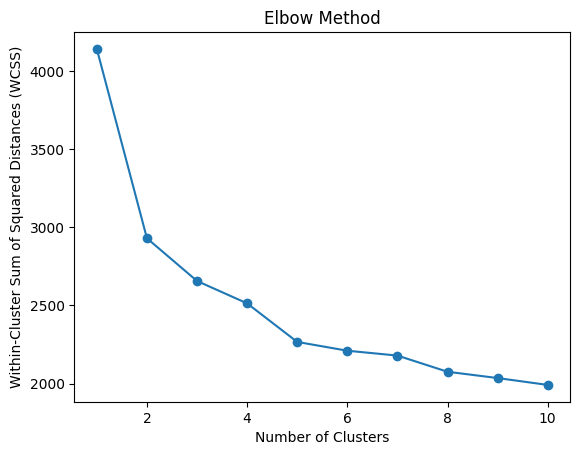

The best number of clusters (k) is: 2


In [7]:
# Initialize an empty list to store the within-cluster sum of squared distances
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squared Distances (WCSS)')
plt.show()

# Programmatically determine the best k (Calculate the second derivative of the WCSS curve)
wcss_diff = np.diff(wcss)
wcss_diff2 = np.diff(wcss_diff)

# Find the index of the maximum curvature (largest second derivative)
best_k = np.argmax(wcss_diff2) + 2  

print(f"The best number of clusters (k) is: {best_k}")



##### Training

In [8]:
k = 2
n_init = 10  
max_iter = 300 
distance_metric = 'euclidean'

kmeans = KMeans(n_clusters=k, init='k-means++', n_init=n_init, max_iter=max_iter, random_state=42)
kmeans.fit(df)

kMeans_labels = kmeans.labels_
kmeans_cluster_centroids = kmeans.cluster_centers_

kmeans_db_index = metrics.davies_bouldin_score(df, kMeans_labels)
kmeans_silhouette_score = metrics.silhouette_score(df, kMeans_labels)
kmeans_ch_score = metrics.calinski_harabasz_score(df, kMeans_labels)

print("Davies-Bouldin index:", kmeans_db_index)
print("Silhouette coefficient:", kmeans_silhouette_score)
print("Calinski-Harabasz index:", kmeans_ch_score)

# Save the model to a file using pickle
with open('../../models/kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)


Davies-Bouldin index: 1.531320595073655
Silhouette coefficient: 0.25449936757836594
Calinski-Harabasz index: 96.8255657859409


### Birch Clustering

##### Hyperparameter tuning

In [9]:
# Define the parameter grid
param_grid = {
    'branching_factor': [50, 100, 200],
    'threshold': [0.5, 1.0, 1.5]
}

# Initialize the BIRCH clustering object
birch = Birch()

# Define custom scorer using Davies-Bouldin index
def custom_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return metrics.davies_bouldin_score(X, labels)

# Perform grid search
grid_search = GridSearchCV(birch, param_grid=param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(df)

# Print the best parameters and best Davies-Bouldin score
print("Best parameters found:", grid_search.best_params_)
print("Best Davies-Bouldin score:", grid_search.best_score_)


Best parameters found: {'branching_factor': 50, 'threshold': 1.5}
Best Davies-Bouldin score: 1.8271055833944587


##### Training

In [10]:
n_clusters = 2
birch = Birch(branching_factor=50, threshold=1.5, n_clusters=n_clusters)
birch.fit(df)

birch_labels = birch.labels_

birch_db_index = metrics.davies_bouldin_score(df, birch_labels)
birch_silhouette_score = metrics.silhouette_score(df, birch_labels)
birch_ch_score = metrics.calinski_harabasz_score(df, birch_labels)

print("Davies-Bouldin index:", birch_db_index)
print("Silhouette coefficient:", birch_silhouette_score)
print("Calinski-Harabasz index:", birch_ch_score)

# Save the model to a file using pickle
with open('../../models/birch_model.pkl', 'wb') as f:
    pickle.dump(birch, f)


Davies-Bouldin index: 1.5384414468346468
Silhouette coefficient: 0.25300994757353906
Calinski-Harabasz index: 96.08209072266985


### DBSCAN

##### Hyperparameter tuning

In [17]:

X = df.values

eps_range = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_range = [3, 5, 7, 10, 15]

best_ch_score = -1 
best_epsilon = None
best_min_samples = None

# Iterate over parameter combinations
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Check if DBSCAN found more than one cluster (excluding noise points)
        unique_labels = set(labels)
        if len(unique_labels) > 1 or (len(unique_labels) == 1 and -1 not in unique_labels):
            ch_score = metrics.calinski_harabasz_score(X, labels)
            
            # Track the best parameters based on Calinski-Harabasz score
            if ch_score > best_ch_score:
                best_ch_score = ch_score
                best_epsilon = eps
                best_min_samples = min_samples

# Perform DBSCAN clustering with the best parameters found
if best_epsilon is not None and best_min_samples is not None:
    dbscan = DBSCAN(eps=best_epsilon, min_samples=best_min_samples)
    labels = dbscan.fit_predict(X)

    # Print the best parameters found based on Calinski-Harabasz score
    print("Best parameters for DBSCAN based on Calinski-Harabasz score:")
    print("Epsilon:", best_epsilon)
    print("Min Samples:", best_min_samples)
    print("Best Calinski-Harabasz score:", best_ch_score)
else:
    print("No valid parameters found for DBSCAN clustering.")

Best parameters for DBSCAN based on Calinski-Harabasz score:
Epsilon: 2.5
Min Samples: 3
Best Calinski-Harabasz score: 5.99255810999435


##### Training

In [18]:
epsilon = best_epsilon
min_samples = best_min_samples

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)


dbscan_labels = dbscan.fit_predict(df)


dbscan_db_index = metrics.davies_bouldin_score(df, dbscan_labels)
dbscan_silhouette_score = metrics.silhouette_score(df, dbscan_labels)
dbscan_ch_score = metrics.calinski_harabasz_score(df, dbscan_labels)

print("Davies-Bouldin index:", dbscan_db_index)
print("Silhouette coefficient:", dbscan_silhouette_score)
print("Calinski-Harabasz index:", dbscan_ch_score)

# Save the model to a file using pickle
with open('../../models/dbscan_model.pkl', 'wb') as f:
    pickle.dump(dbscan, f)


Davies-Bouldin index: 1.9639493497997087
Silhouette coefficient: -0.14013395137995927
Calinski-Harabasz index: 5.99255810999435


### Gaussian Mixture Models (GMM)

##### Hyperparameter tuning

In [20]:
# Convert DataFrame to NumPy array
X = df.values

# Parameter tuning using BIC and AUC
lowest_bic = np.inf
best_params_bic = {}
best_auc = -np.inf
best_params_auc = {}

bic = []
auc_scores = []

# Define range of components and covariance types
n_components_range = range(2, 20)
covariance_types = ['full', 'tied', 'diag', 'spherical']

for cov_type in covariance_types:
    for n_components in n_components_range:
        # Fit GaussianMixture
        gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type)
        gmm.fit(X)
        
        # Calculate BIC
        bic.append(gmm.bic(X))
        
        # Update best parameters if this model has lower BIC
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_params_bic = {'n_components': n_components, 'covariance_type': cov_type}
        
        # Calculate AUC (using silhouette score as a proxy)
        labels = gmm.predict(X)
        silhouette = metrics.silhouette_score(X, labels)
        auc_scores.append(silhouette)
        
        # Update best parameters if this model has higher AUC
        if silhouette > best_auc:
            best_auc = silhouette
            best_params_auc = {'n_components': n_components, 'covariance_type': cov_type}

print("Best BIC:", lowest_bic)
print("Best Parameters (BIC):", best_params_bic)
print("Best AUC (Silhouette Score):", best_auc)
print("Best Parameters (AUC):", best_params_auc)



Best BIC: 766.4364487471667
Best Parameters (BIC): {'n_components': 18, 'covariance_type': 'diag'}
Best AUC (Silhouette Score): 0.25449936757836594
Best Parameters (AUC): {'n_components': 2, 'covariance_type': 'tied'}


##### Training

In [21]:
n_clusters = 2

gmm = GaussianMixture(n_components=n_clusters,covariance_type='tied')
gmm.fit(df)

gmm_labels = gmm.predict(df)

gmm_db_index = metrics.davies_bouldin_score(df, gmm_labels)

gmm_silhouette_score = metrics.silhouette_score(df, gmm_labels)

gmm_ch_score = metrics.calinski_harabasz_score(df, gmm_labels)

print("Davies-Bouldin index:", gmm_db_index)
print("Silhouette coefficient:", gmm_silhouette_score)
print("Calinski-Harabasz index:", gmm_ch_score)

# Save the model to a file using pickle
with open('../../models/gmm_model.pkl', 'wb') as f:
    pickle.dump(gmm, f)


Davies-Bouldin index: 1.531320595073655
Silhouette coefficient: 0.25449936757836594
Calinski-Harabasz index: 96.8255657859409


In [22]:
df['cluster_label'] = kMeans_labels

In [25]:
df.to_csv('../../data/clustered/Roommates.csv', index=False)

### Visualization of The Clustering Results

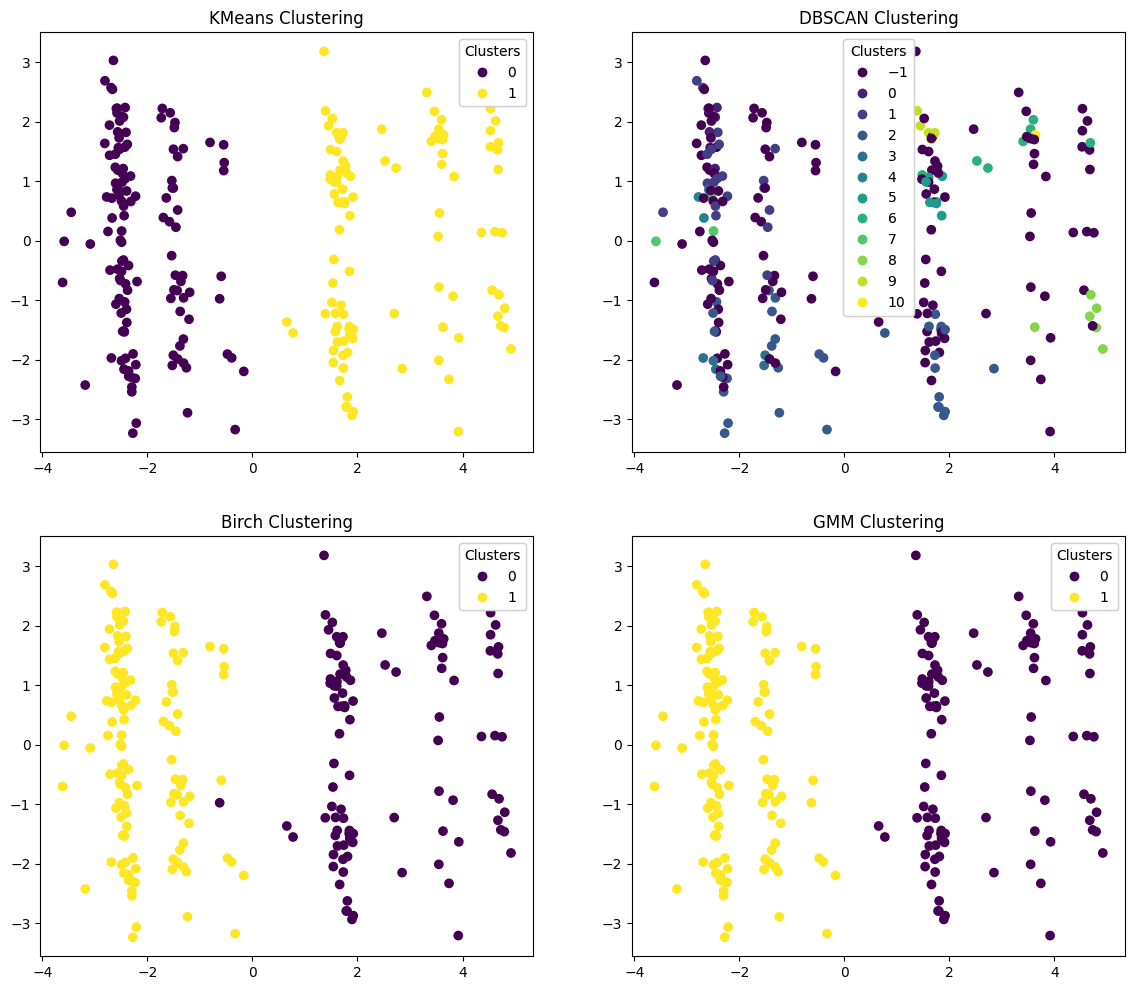

In [26]:
from sklearn.decomposition import PCA
# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

# Plotting the clusters
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Plot KMeans clusters
scatter = ax[0, 0].scatter(df_pca[:, 0], df_pca[:, 1], c=kMeans_labels, cmap='viridis')
legend1 = ax[0, 0].legend(*scatter.legend_elements(), title="Clusters")
ax[0, 0].add_artist(legend1)
ax[0, 0].set_title('KMeans Clustering')

# Plot DBSCAN clusters
scatter = ax[0, 1].scatter(df_pca[:, 0], df_pca[:, 1], c=dbscan_labels, cmap='viridis')
legend2 = ax[0, 1].legend(*scatter.legend_elements(), title="Clusters")
ax[0, 1].add_artist(legend2)
ax[0, 1].set_title('DBSCAN Clustering')

# Plot Birch clusters
scatter = ax[1, 0].scatter(df_pca[:, 0], df_pca[:, 1], c=birch_labels, cmap='viridis')
legend3 = ax[1, 0].legend(*scatter.legend_elements(), title="Clusters")
ax[1, 0].add_artist(legend3)
ax[1, 0].set_title('Birch Clustering')

# Plot GMM clusters
scatter = ax[1, 1].scatter(df_pca[:, 0], df_pca[:, 1], c=gmm_labels, cmap='viridis')
legend4 = ax[1, 1].legend(*scatter.legend_elements(), title="Clusters")
ax[1, 1].add_artist(legend4)
ax[1, 1].set_title('GMM Clustering')

# Save each plot with a specific name
plot_names = ['kmeans_cluster_plot.png', 'dbscan_cluster_plot.png', 'birch_cluster_plot.png', 'gmm_cluster_plot.png']

for i, ax in enumerate(ax.flat):
    ax.figure.savefig(plot_names[i])
    
plt.show()

### Silhouette Analysis

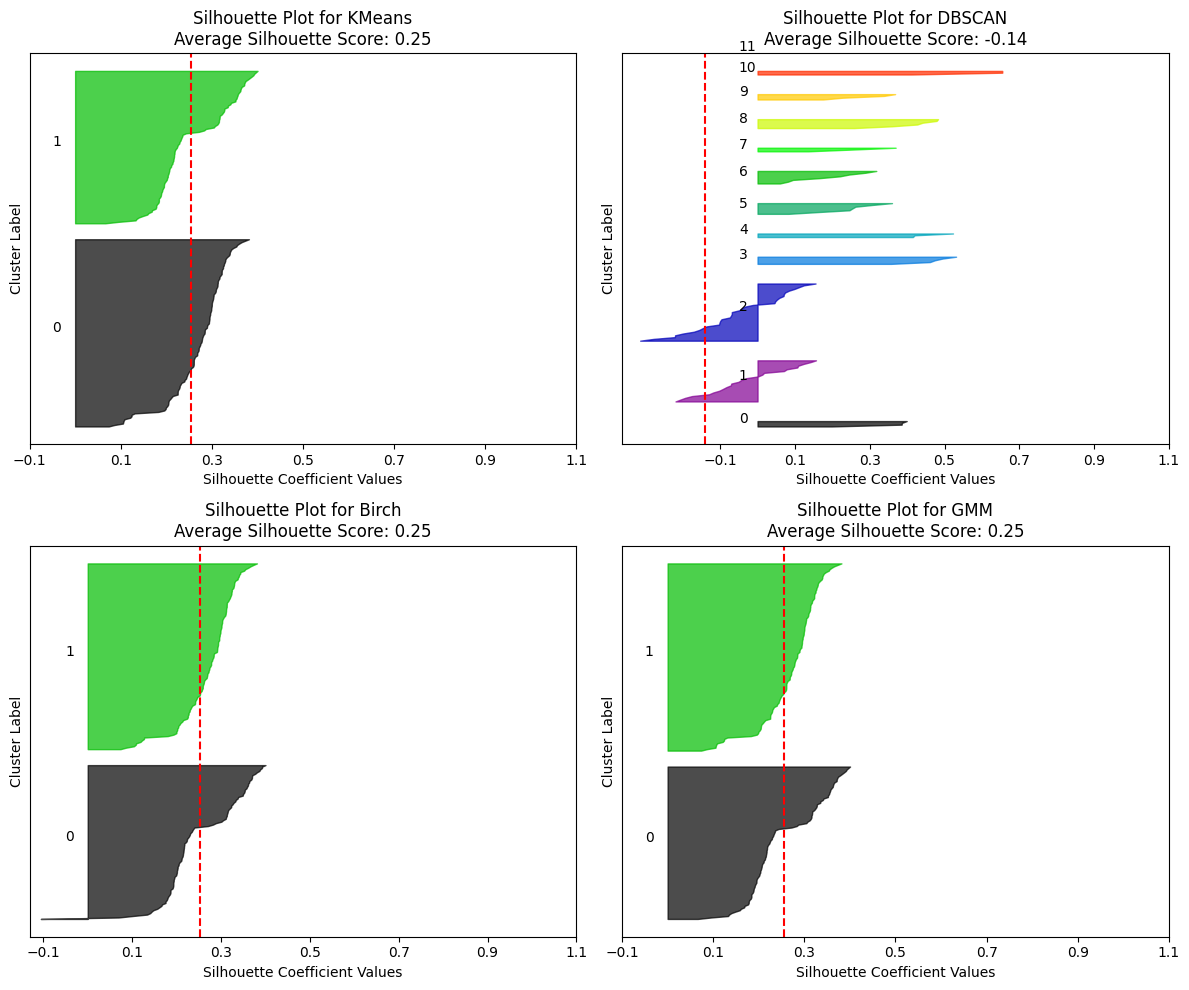

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score



kmeans_labels = kMeans_labels  
kmeans_silhouette_score = kmeans_silhouette_score  

dbscan_labels = dbscan_labels  
dbscan_silhouette_score = dbscan_silhouette_score 

birch_labels = birch_labels
birch_silhouette_score = birch_silhouette_score

gmm_labels = gmm_labels 
gmm_silhouette_score = gmm_silhouette_score


# Function to create silhouette plots
def plot_silhouette_analysis(X, cluster_labels, title, silhouette_avg, ax):
    n_clusters = len(np.unique(cluster_labels))
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title(f"Silhouette Plot for {title}\nAverage Silhouette Score: {silhouette_avg:.2f}")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([]) 
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_silhouette_analysis(df, kmeans_labels, "KMeans", kmeans_silhouette_score, ax=axs[0, 0])

plot_silhouette_analysis(df, dbscan_labels, "DBSCAN", dbscan_silhouette_score, ax=axs[0, 1])

plot_silhouette_analysis(df, birch_labels, "Birch", birch_silhouette_score, ax=axs[1, 0])

plot_silhouette_analysis(df, gmm_labels, "GMM", gmm_silhouette_score, ax=axs[1, 1])

plt.tight_layout()

plt.savefig("Silhouette_Plots.png")

plt.show()

### Run-Time Analysis

C:\Users\zahra\AppData\Local\Temp\ipykernel_10816\2006228238.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=algorithms, y=complexities, palette='viridis')


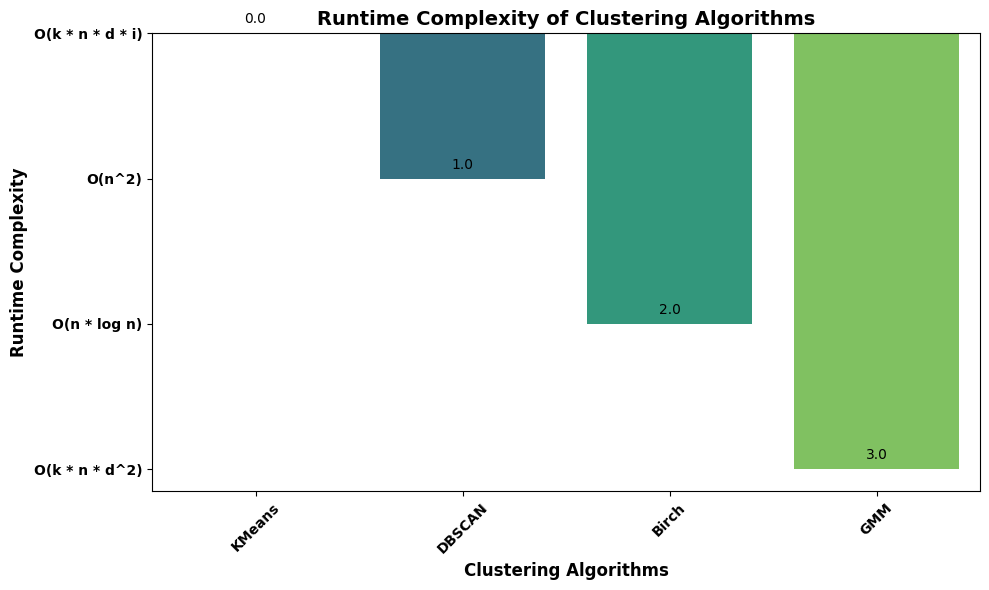

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering algorithms and their simplified runtime complexities
algorithms = ['KMeans', 'DBSCAN', 'Birch', 'GMM']
complexities = ['O(k * n * d * i)', 'O(n^2)', 'O(n * log n)', 'O(k * n * d^2)']

# Create a figure and axis using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=algorithms, y=complexities, palette='viridis')

# Adding labels and title
plt.xlabel('Clustering Algorithms', fontsize=12, fontweight='bold')
plt.ylabel('Runtime Complexity', fontsize=12, fontweight='bold')
plt.title('Runtime Complexity of Clustering Algorithms', fontsize=14, fontweight='bold')

# Adding text annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# Display the plot
plt.xticks(rotation=45, fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()
